# ⭐🐟 Image Tilling for Small Object Detection ⭐🐟
### By [Luca Ordronneau](https://www.kaggle.com/lucaordronneau)
## 📌 Objective
I'm introducing the image tilling notebook for the competition: **TensorFlow - Help Protect the Great Barrier Reef** which allows you to cut an image into **several tiles with a readjustment of the bounding box**.
## 📌 Main Idea
This idea came to me after I noticed that the bounding boxes around the starfish were a very small part of the image (a mean area less than 1%). This challenge refers to a small object detection problem.
## 📌 What are the advantages of image tilling ?
- Faster training due to smaller image size
- Very effective detection of smaller objects

Here is an interesting research paper on the subject: [The Power of Tiling for Small Object Detection](https://openaccess.thecvf.com/content_CVPRW_2019/papers/UAVision/Unel_The_Power_of_Tiling_for_Small_Object_Detection_CVPRW_2019_paper.pdf)

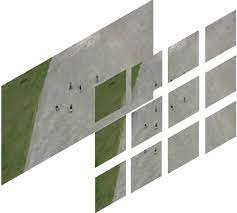

## ✨ Please **UPVOTE** if you find this notebook helpful.

### Moreover I would be interested in teaming up for this challenge.

### Enjoy your reading, any comments are welcome

# 📚 Import Librairies

In [ ]:
import os
import ast
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
import seaborn as sns

# 📂 Variables and Data preparation

In [ ]:
REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR      = '/kaggle/input/tensorflow-great-barrier-reef'
IMAGE_SPLIT   = 2 # Image split : (eg : 2, 4...)
WIDTH         = 1280
HEIGHT        = 720

In [ ]:
print('All image size will be : ('+str(HEIGHT//IMAGE_SPLIT)+', '+str(WIDTH//IMAGE_SPLIT)+')')

In [ ]:
df = pd.read_csv(f'{ROOT_DIR}/train.csv')

In [ ]:
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

In [ ]:
df['nb_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.nb_bbox>0).value_counts(normalize=True)*100
print(f"No BBOX: {data[0]:0.2f}% | With BBOX: {data[1]:0.2f}%")

In [ ]:
if REMOVE_NOBBOX:
    df = df.query("nb_bbox>0")

In [ ]:
def get_path(row):
    row['old_image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

df = df.progress_apply(get_path, axis=1)

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

df['bboxes'] = df.annotations.progress_apply(get_bbox)

In [ ]:
df.head()

In [ ]:
def plot_image_and_bboxes(img, bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.axis('off')
    ax.imshow(img)
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

In [ ]:
def get_image(img_name):
    return np.array(Image.open(img_name))

# 📈 Exploring data on the distribution of the bounding box area

In [ ]:
def know_data(width = 1280, height = 720):
    percentage_area = []
    for img_name in df['old_image_path'].tolist():
        bboxes = np.array(df.loc[df["old_image_path"] == img_name]["bboxes"].values[0])
        t = 100 * bboxes[..., [2]] * bboxes[..., [3]] / (width * height) # percentage 
        flat_list = t.flatten().tolist()
        percentage_area.extend(flat_list)
    return percentage_area

As said before we can notice that bounding boxes represents a small part of the image (**less than 1% of the image**).

In [ ]:
area = know_data()

# plotting the distribution of percentage area
sns.displot(area)
plt.xlabel("Percentage area of occupied by objects in an image")
plt.title("Distribution plot of percentage area of objects in an image")
plt.grid()
plt.show()

In [ ]:
df_describe = pd.DataFrame(area)
df_describe.describe().T

# 🔨 Functions for image tiles

In [ ]:
def image_tiler(img, s_h=180, s_w=320):
    tiles = [img[x:x+s_h,y:y+s_w] for x in range(0,img.shape[0],s_h) for y in range(0,img.shape[1],s_w)]
    return tiles  

In [ ]:
def tiler_plot(img_name, bboxes, s_h = 180, s_w = 320, height = 720, width = 1280):
    basename = os.path.basename(os.path.splitext(img_name)[0])

    tiles_dict = {}
    boxes = []
    
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.axis('off')
    plt.gca().invert_yaxis()
    
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
      
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            ax.plot(*pol.exterior.xy)

            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    new_box = inter.envelope 
                    ax.plot(*new_box.exterior.coords.xy)

In [ ]:
def tiler(img_name, bboxes, s_h = 180, s_w = 320, height = 720, width = 1280):
    basename   = os.path.basename(os.path.splitext(img_name)[0])

    tiles_dict = {}
    boxes      = []
    
    for bbox in bboxes:
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0] + bbox[2]
        y2 = bbox[1] + bbox[3]
        boxes.append(Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)]))
    for i in range((height // s_h)):
        for j in range((width // s_w)):
            
            x1 = j*s_w
            y1 = height - (i*s_h)
            x2 = ((j+1)*s_w)
            y2 = (height - (i+1)*s_h)
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            
            slice_labels = []
            
            for box in boxes:
                if pol.intersects(box):
                    inter = pol.intersection(box)                        
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    new_width  = (max(x) - min(x))
                    new_height = (max(y) - min(y))
                    
                    # Get new_x min and new_y min
                    new_x = (min(x) - x1)
                    new_y = (min(y) - y2)
                    
                    # Remove small bbox (unsignificant for training)
                    if ((new_width > 14) and (new_height > 14)):
                        slice_labels.append([new_x, new_y, new_width, new_height])
            tiles_dict[basename + "-" + str(IMAGE_SPLIT-i-1)+"-"+str(j)] = slice_labels
    return dict(sorted(tiles_dict.items()))

In [ ]:
def keep_bboxes_tiles(tiles, tiles_dict):
    bboxes_tiles = {}
    tiles_keys = [*tiles_dict]
    for k, v in tiles_dict.items():
        if len(v):
            tile_index = tiles_keys.index(k)
            bboxes_tiles[k] = np.array([tiles[tile_index], np.array(v)], dtype=object)
    return bboxes_tiles

# 🔭 Result of a tiled image
### Original image

In [ ]:
old_image_path = df['old_image_path'].tolist()
img_name   = random.choice(old_image_path)

img        = get_image(img_name)
bboxes     = df.loc[df["old_image_path"] == img_name]["bboxes"].values[0]

plot_image_and_bboxes(img, bboxes)

### Tiled image 

In [ ]:
tiles_dict = tiler(img_name, bboxes, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)
tiles  = image_tiler(img, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT)

_, axs = plt.subplots(IMAGE_SPLIT, IMAGE_SPLIT, figsize=(10, 8))
axs = axs.flatten()
for img, ax in zip(tiles, axs):
    ax.axis('off')
    ax.imshow(img)
plt.subplots_adjust(wspace=0.05, hspace=-0.3)
plt.show()

### Location of bounding boxes on the tiles of the image

In [ ]:
tiler_plot(img_name, bboxes, s_h = HEIGHT//IMAGE_SPLIT, s_w = WIDTH//IMAGE_SPLIT, height = HEIGHT, width = WIDTH)

### Displaying tiles that contain bounding boxes
The dictionary is formed in this way :  **key** : *tile_name (imgid-row-column)*, **values** : *(img array, bboxes)*

In [ ]:
to_save = keep_bboxes_tiles(tiles, tiles_dict)
for k, v in to_save.items():
    print("IMAGE NAME :",k)
    print("NEW BBOXES :",v[1])
    plot_image_and_bboxes(v[0], v[1])

I get quite interesting results especially on the detection of **small starfish**. Moreover, I train on tiles of size 320 and I make my inference on images of size 1280. I combine this model with another model trained on images of size 1280.

## ✨ Please **UPVOTE** if you find this notebook helpful.

### Moreover I would be interested in teaming up for this challenge.